# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [3]:
import geopandas as gpd
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [4]:
# Alter

dfA = pd.read_csv('dataX.csv', sep = ';')

# Removing all rows whoch are empty

dfA.replace('-',None, inplace = True)

dfA.dropna(subset=['unter 3 Jahre'], inplace = True)

dfA



,Datum,B-code,Landkreis,unter 3 Jahre,3 bis unter 6 Jahre,6 bis unter 10 Jahre,10 bis unter 15 Jahre,15 bis unter 18 Jahre,18 bis unter 20 Jahre,20 bis unter 25 Jahre,...,30 bis unter 35 Jahre,35 bis unter 40 Jahre,40 bis unter 45 Jahre,45 bis unter 50 Jahre,50 bis unter 55 Jahre,55 bis unter 60 Jahre,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,Insgesamt
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",2709,2561,3127,3775,2284,1893,8521,...,6463,5135,4977,4855,6316,6342,5565,8861,9532,91113
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",6683,6485,7895,9617,5761,4834,21478,...,20756,16442,14113,13308,16801,17553,14594,22414,24416,246243
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",5371,5667,7127,8936,5508,3936,13454,...,14604,13005,12474,12300,16194,17318,14692,23374,27556,216277
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",2135,2128,2853,3697,2298,1532,4842,...,5325,4690,4560,4571,6005,6275,5569,8583,9749,79496
4,31.12.2021,1051,"Dithmarschen, Landkreis",3241,3458,4432,5992,3758,2747,7122,...,7277,6906,7029,7536,10827,11875,10669,16993,17130,133969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,31.12.2021,16073,"Saalfeld-Rudolstadt, Landkreis",2043,2430,3354,4119,2330,1501,3530,...,5184,5937,5938,5491,7398,9091,9358,15113,15439,100969
472,31.12.2021,16074,Saale-Holzland-Kreis,1726,2243,3100,3724,2052,1350,3035,...,4343,5331,5374,4603,6136,7515,7079,11770,10814,82513
473,31.12.2021,16075,Saale-Orla-Kreis,1725,2044,2803,3423,1938,1202,2878,...,3951,4846,4862,4454,5925,7230,7218,11685,10536,79030
474,31.12.2021,16076,"Greiz, Landkreis",1939,2290,3371,4023,2338,1439,2996,...,4422,5428,5766,5072,7090,8995,9020,14940,14663,96102


In [5]:
# read the data into a DataFrame



dfA = dfA.apply(pd.to_numeric, errors = 'ignore')

age_ranges = [
    ('20 bis unter 25 Jahre', '25 bis unter 30 Jahre'),
    ('30 bis unter 35 Jahre', '35 bis unter 40 Jahre'),
    ('40 bis unter 45 Jahre', '45 bis unter 50 Jahre'),
    ('50 bis unter 55 Jahre', '55 bis unter 60 Jahre')
]

# loop over the age ranges and add them together
for age_range in age_ranges:
    col1, col2 = age_range
    lower_bound = int(col1.split()[0])
    upper_bound = int(col2.split()[0])
    new_col_name = f'{lower_bound}-{upper_bound}'
    dfA[new_col_name] = dfA[col1] + dfA[col2]

# drop irrelevant ages 

dfA.drop(['unter 3 Jahre', '3 bis unter 6 Jahre', '6 bis unter 10 Jahre', '10 bis unter 15 Jahre', '15 bis unter 18 Jahre', '18 bis unter 20 Jahre', '20 bis unter 25 Jahre', '25 bis unter 30 Jahre', '30 bis unter 35 Jahre', '35 bis unter 40 Jahre', '40 bis unter 45 Jahre', '45 bis unter 50 Jahre', '50 bis unter 55 Jahre', '55 bis unter 60 Jahre', '60 bis unter 65 Jahre'], axis=1, inplace=True)




In [6]:
#remame the columns 

dfA_final = dfA.rename(columns = {'65 bis unter 75 Jahre':'65 to under 75 years', 'Landkreis':'County', 'Datum':'Date','75 Jahre und mehr':'75 years and older', 'Insgesamt':'Total', '20-25':'20 to under 30 years', '30-35':'30 to under 40 years', '40-45':'40 to under 50 years', '50-55':'50 to under 60 years' })

# new column order 

new_column_order = ['Date', 'B-code', 'County', '20 to under 30 years', '30 to under 40 years', '40 to under 50 years', '50 to under 60 years', '65 to under 75 years', '75 years and older', 'Total']
dfA_final = dfA_final.reindex(columns=new_column_order)

# display the modified DataFrame
dfA_final

,Date,B-code,County,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,Total
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,91113
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,246243
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,216277
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,79496
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,133969
...,...,...,...,...,...,...,...,...,...,...
471,31.12.2021,16073,"Saalfeld-Rudolstadt, Landkreis",6243,11121,11429,16489,15113,15439,100969
472,31.12.2021,16074,Saale-Holzland-Kreis,5353,9674,9977,13651,11770,10814,82513
473,31.12.2021,16075,Saale-Orla-Kreis,5188,8797,9316,13155,11685,10536,79030
474,31.12.2021,16076,"Greiz, Landkreis",5306,9850,10838,16085,14940,14663,96102


In [7]:
# Kraftfahrzeug

dfK = pd.read_csv('dataY.csv', sep = ';')

# Drop columns which are empty

dfK.drop(['Leichtkraftraeder', 'Gewoehnliche Zugmaschinen'], axis = 1, inplace=True)

# Removing all rows which are empty

dfK.replace('-',None, inplace = True)

dfK.dropna(subset=['Kfz'], inplace = True)

dfK



,Datum,B-code,Stadt,Kfz,Kraftraeder,Motorraeder,Pkw,Pkw mit Ottomotor,Pkw mit Dieselmotor,Kraftomnibusse,Lkw,Lkw mit Spezialaufbau,Zugmaschinen,Sattelzugmaschinen,Ackerschlepper,Uebrige Kfz,Wohnmobile,Kfz-Anhaenger,Kfz-Anhaenger zur Lastenbefoerderung,Sattelanhaenger
0,01.01.2022,1001,"Flensburg, kreisfreie Stadt",52047,2942,2884,45488,26809,16230,81,2707,920,591,290,301,238,1489,5507,2091,70
1,01.01.2022,1002,"Kiel, kreisfreie Stadt",131615,8314,8144,112154,71089,35234,947,8313,3217,976,327,649,911,3650,11419,4486,484
2,01.01.2022,1003,"L�beck, kreisfreie Stadt",120776,8500,8339,102167,66824,30127,227,7614,2752,1575,834,741,693,2359,14280,5300,2719
3,01.01.2022,1004,"Neum�nster, kreisfreie Stadt",51876,3469,3376,43435,26943,14163,72,3742,1477,768,357,411,390,864,7320,3412,476
4,01.01.2022,1051,"Dithmarschen, Landkreis",108069,8160,7816,83763,48386,32319,83,7003,2772,8193,1174,7019,867,2184,24533,12965,1810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,01.01.2022,16073,"Saalfeld-Rudolstadt, Landkreis",78305,6375,6139,60360,40236,17822,219,6338,2673,4479,170,4309,534,613,14295,8064,245
472,01.01.2022,16074,Saale-Holzland-Kreis,64706,4896,4719,49777,32484,15114,110,5250,2320,4171,309,3862,502,583,12026,6933,427
473,01.01.2022,16075,Saale-Orla-Kreis,67304,5139,4934,50465,32606,16411,27,5791,2557,5390,300,5090,492,471,15772,9421,685
474,01.01.2022,16076,"Greiz, Landkreis",78547,5996,5791,60165,39900,18081,95,7364,3403,4263,444,3819,664,623,14548,8405,397


In [8]:
# Kraftfahrzeug


dfK = pd.read_csv('dataY.csv', sep = ';')


# Drop columns which are empty


dfK.drop(['Leichtkraftraeder', 'Gewoehnliche Zugmaschinen'], axis = 1, inplace=True)


# Removing all rows which are empty


dfK.replace('-',None, inplace = True)


dfK.dropna(subset=['Kfz'], inplace = True)


dfK


# dropping useless columns


dfK_new = dfK.drop(dfK.columns[[3, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]], axis=1)


# transform strings to numbers


dfK_new = dfK_new.apply(pd.to_numeric, errors = 'ignore')


# creating the sum of Kraftraeder, Motorraeder


dfK_new['Zweiraeder'] = dfK_new[['Kraftraeder', 'Motorraeder']].sum(axis=1)


# creating the sum of Pkw mit Ottomotor and Dieselmotor


dfK_new['Pkw1'] = dfK_new[['Pkw mit Ottomotor', 'Pkw mit Dieselmotor']].sum(axis=1)


# creating the sum of Pkw and Zweiraeder and Wohnmobile


dfK_new['KFZ'] = dfK_new[['Zweiraeder', 'Pkw1', 'Wohnmobile']].sum(axis=1)


# deleting Kraftraeder, Motorraeder, Pkw


dfK_new = dfK_new.drop(dfK_new.columns[[3, 4, 5]], axis=1)


# changing the order of the columns


new_order = ['Datum', ' B-code', ' Stadt', 'Pkw mit Ottomotor', 'Pkw mit Dieselmotor', 'Pkw1', 'Wohnmobile', 'Zweiraeder', 'KFZ']


# Reindex the dataframe with the desired order of columns
dfK_new = dfK_new.reindex(columns=new_order)


# rename the columns
dfK_new.rename(columns={'Datum':'date', ' B-code':'B-code', ' Stadt':'County', 'Pkw mit Ottomotor':'cars petrol', 'Pkw mit Dieselmotor': 'cars diesel', 'Pkw1':'cars', 'Wohnmobile':'campers', 'Zweiraeder':'two-wheelers', 'KFZ':'vehicles'}, inplace=True)


dfK_new


,date,B-code,County,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles
0,01.01.2022,1001,"Flensburg, kreisfreie Stadt",26809,16230,43039,1489,5826,50354
1,01.01.2022,1002,"Kiel, kreisfreie Stadt",71089,35234,106323,3650,16458,126431
2,01.01.2022,1003,"L�beck, kreisfreie Stadt",66824,30127,96951,2359,16839,116149
3,01.01.2022,1004,"Neum�nster, kreisfreie Stadt",26943,14163,41106,864,6845,48815
4,01.01.2022,1051,"Dithmarschen, Landkreis",48386,32319,80705,2184,15976,98865
...,...,...,...,...,...,...,...,...,...
471,01.01.2022,16073,"Saalfeld-Rudolstadt, Landkreis",40236,17822,58058,613,12514,71185
472,01.01.2022,16074,Saale-Holzland-Kreis,32484,15114,47598,583,9615,57796
473,01.01.2022,16075,Saale-Orla-Kreis,32606,16411,49017,471,10073,59561
474,01.01.2022,16076,"Greiz, Landkreis",39900,18081,57981,623,11787,70391


In [27]:
merged = pd.merge(dfA_final, dfK_new, on='B-code')

#merged = merged.drop(('date', 'County_y'), axis = 1, inplace=True)

merged



,Date,B-code,County_x,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,Total,date,County_y,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,91113,01.01.2022,"Flensburg, kreisfreie Stadt",26809,16230,43039,1489,5826,50354
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,246243,01.01.2022,"Kiel, kreisfreie Stadt",71089,35234,106323,3650,16458,126431
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,216277,01.01.2022,"L�beck, kreisfreie Stadt",66824,30127,96951,2359,16839,116149
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,79496,01.01.2022,"Neum�nster, kreisfreie Stadt",26943,14163,41106,864,6845,48815
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,133969,01.01.2022,"Dithmarschen, Landkreis",48386,32319,80705,2184,15976,98865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,31.12.2021,16073,"Saalfeld-Rudolstadt, Landkreis",6243,11121,11429,16489,15113,15439,100969,01.01.2022,"Saalfeld-Rudolstadt, Landkreis",40236,17822,58058,613,12514,71185
395,31.12.2021,16074,Saale-Holzland-Kreis,5353,9674,9977,13651,11770,10814,82513,01.01.2022,Saale-Holzland-Kreis,32484,15114,47598,583,9615,57796
396,31.12.2021,16075,Saale-Orla-Kreis,5188,8797,9316,13155,11685,10536,79030,01.01.2022,Saale-Orla-Kreis,32606,16411,49017,471,10073,59561
397,31.12.2021,16076,"Greiz, Landkreis",5306,9850,10838,16085,14940,14663,96102,01.01.2022,"Greiz, Landkreis",39900,18081,57981,623,11787,70391


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [21]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [22]:
m = folium.Map()
m.save("footprint.html")

In [23]:
#rename AGS to B-code to prepare for merging

dfgeo = gpd.read_file("DE-counties.geojson")

dfgeo.rename(columns={"AGS":"B-code"}, inplace=True)

In [24]:
#check if it worked

print(dfgeo[["B-code"]])

    B-code
0    01001
1    01002
2    01003
3    01004
4    01051
..     ...
426  13003
427  13072
428  13073
429  13074
430  13075

[431 rows x 1 columns]


In [47]:
#merge DE counties geofile with variables

dfgeo['B-code']=dfgeo['B-code'].astype(int)

merged['B-code']=merged['B-code'].astype(int)

merged1 = pd.merge(merged, dfgeo, on='B-code', how="left")

merged1.drop_duplicates(subset=['B-code'], inplace=True)

geomerged = gpd.GeoDataFrame(merged1)

In [48]:
merged1


,Date,B-code,County_x,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,Total,...,FK_S3,NUTS,ARS_0,AGS_0,WSK,DEBKG_ID,RS,SDV_RS,RS_0,geometry
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,91113,...,R,DEF01,010010000000,01001000,2008-01-01,DEBKGDL20000002R,01001,010010000000,010010000000,"POLYGON ((9.41266 54.82264, 9.42293 54.82322, ..."
2,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,246243,...,R,DEF02,010020000000,01002000,2006-01-01,DEBKGDL20000E43X,01002,010020000000,010020000000,"POLYGON ((10.16916 54.43138, 10.18877 54.41108..."
4,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,216277,...,R,DEF03,010030000000,01003000,2006-02-01,DEBKGDL20000DYM9,01003,010030000000,010030000000,"POLYGON ((10.87684 53.98737, 10.88454 53.97820..."
5,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,79496,...,R,DEF04,010040000000,01004000,1970-04-26,DEBKGDL20000E4KX,01004,010040000000,010040000000,"POLYGON ((9.99545 54.14972, 10.00821 54.14217,..."
6,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,133969,...,R,DEF05,010510000000,01051000,2011-08-01,DEBKGDL20000E14G,01051,010510044044,010510000000,"MULTIPOLYGON (((9.07777 54.36249, 9.09085 54.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,31.12.2021,16073,"Saalfeld-Rudolstadt, Landkreis",6243,11121,11429,16489,15113,15439,100969,...,R,DEG0I,160730000000,16073000,2019-01-01,DEBKGDL20000E6O4,16073,160730077077,160730000000,"POLYGON ((11.26298 50.83328, 11.27159 50.82683..."
425,31.12.2021,16074,Saale-Holzland-Kreis,5353,9674,9977,13651,11770,10814,82513,...,R,DEG0J,160740000000,16074000,2009-01-01,DEBKGDL20000DZT7,16074,160745052018,160740000000,"POLYGON ((11.69798 51.08352, 11.70081 51.06940..."
426,31.12.2021,16075,Saale-Orla-Kreis,5188,8797,9316,13155,11685,10536,79030,...,R,DEG0K,160750000000,16075000,2009-01-01,DEBKGDL20000E0F6,16075,160750098098,160750000000,"POLYGON ((11.83003 50.78988, 11.83320 50.78476..."
427,31.12.2021,16076,"Greiz, Landkreis",5306,9850,10838,16085,14940,14663,96102,...,R,DEG0L,160760000000,16076000,2009-01-01,DEBKGDL20000E65V,16076,160760022022,160760000000,"POLYGON ((12.19167 50.96358, 12.20069 50.95611..."


In [37]:
# ratios

geomerged["ratio_Wohnmobile"] = geomerged["campers"] / geomerged["Total"]

  Total                               GEN
  91113                         Flensburg
  91113                         Flensburg
 246243                              Kiel
 246243                              Kiel
 216277                            Lübeck
  79496                        Neumünster
 133969                      Dithmarschen
 133969                      Dithmarschen
 133969                      Dithmarschen
 200819               Herzogtum Lauenburg
 167560                     Nordfriesland
 167560                     Nordfriesland
 202014                       Ostholstein
 202014                       Ostholstein
 318326                         Pinneberg
 318326                         Pinneberg
 318326                         Pinneberg
 129687                              Plön
 129687                              Plön
 276053             Rendsburg-Eckernförde
 276053             Rendsburg-Eckernförde
 203799               Schleswig-Flensburg
 203799               Schleswig-Fl

<AxesSubplot: >

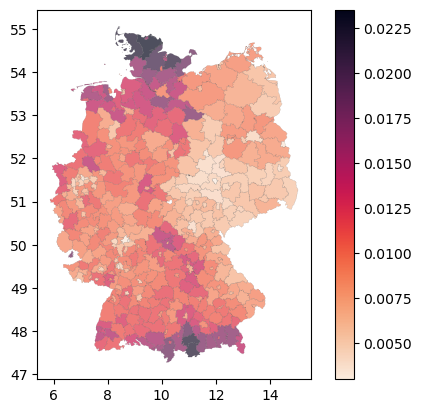

In [38]:
#shoutout to https://github.com/jgehrcke/covid-19-germany-gae

import seaborn

fig, ax = plt.subplots()

print(geomerged[['Total', 'GEN']].to_string(index=False))

#graph
geomerged.plot(
    ax=ax,
    alpha=0.7,
    column="ratio_Wohnmobile",
    linewidth=0.1,
    edgecolor="#555",
    categorical=False,
    legend=True,
        # cmap="autumn_r",
        # This is a key decision here. Lovely background info:
        # https://seaborn.pydata.org/tutorial/color_palettes.html
        # Use a sequential one.
    cmap=seaborn.color_palette("rocket_r", as_cmap=True),
    )


# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

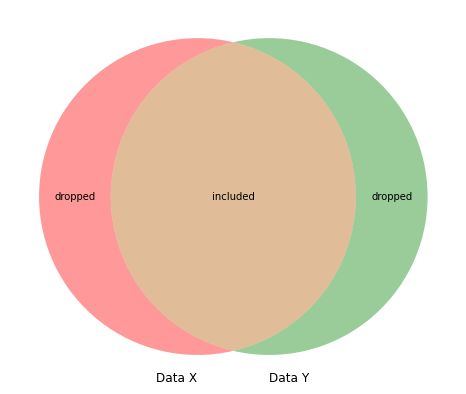

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.